In [143]:
import pandas as pd
import numpy as np
from pandas_datareader import data as pdr
import datetime as dt
import matplotlib.pyplot as plt
import seaborn as sns
sns.set()

import warnings
warnings.filterwarnings("ignore")

In [792]:
start = dt.datetime(2019, 3, 2)
end = dt.datetime(2020, 4, 20)

index_ticker = ['^GDAXI']

index_data = pdr.DataReader(index_ticker,'yahoo',start=start, end=end)

In [794]:
# get df of Adj close prices
main = pd.DataFrame(index_data.loc[:, (('Volume','Adj Close'), '^GDAXI')])
main.columns = main.columns.droplevel()
main.columns = ['Volume','Adj Close']

In [391]:
# PCF 

def price_cyclicality_function(df: pd.DataFrame, p1=20, p2=50, n=20, a=0.33) -> pd.DataFrame:
    if p1 > p2:
        return df
     
    # Make a DataFrame with the same number of rows
    tmp = pd.DataFrame(index=df.index)
     
    # Get calculate our moving averages using a function from talib
    tmp['Ma'] = df.rolling(window=p1).mean()
    tmp['ma'] = df.rolling(window=p2).mean()
     
    # Find min/max values for Ma - ma in a window size of n
    tmp['min'] = (tmp['Ma'] - tmp['ma']).rolling(n).min()
    tmp['max'] = (tmp['Ma'] - tmp['ma']).rolling(n).max()
     
    # Get the derivative
    tmp['delta'] = (
        ( tmp['max'] - (tmp['Ma'] - tmp['ma']) )/
        ( tmp['max'] - tmp['min'] )
    )
     
    # PCY
    tmp['pcy'] = 0.0
    for i in range(p2+n, len(df)):
        tmp.at[i, 'pcy'] = (a*(tmp.at[i, 'delta'] - tmp.at[i-1, 'pcy']) + tmp.at[i-1, 'pcy'])
    tmp['pcy'] = tmp['pcy'] * 100
     
    return tmp

In [795]:
indicators = pd.DataFrame(index=main.index)
indicators['PCY'] = price_cyclicality_function(main.reset_index()[['Adj Close']])['pcy'].values
indicators['VOC'] = price_cyclicality_function(main.reset_index()[['Volume']])['pcy'].values

$BuySignal_i = (VOC_{i-2} > VOC_{i-1}) \wedge (VOC_{i-1} < VOC_{i})$

1.4901901234352037


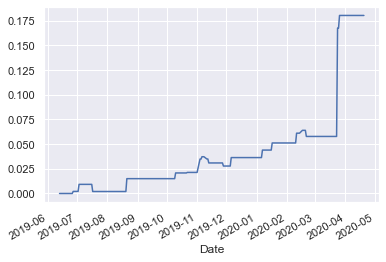

In [389]:
df = pd.DataFrame()
df.index = main.index
df['VOC'] = indicators['VOC']
df['Adj Close'] = main['Adj Close']
df['RETURNS'] = df['Adj Close'].pct_change().fillna(0)
df['POS'] = np.where(((df['VOC'].shift(2) > df['VOC'].shift(1)) & (df['VOC'].shift(1) < df['VOC'])), 1, 0)
df['STRATEGY'] = df['POS'].shift(1) * df['RETURNS']
df[df['VOC'] != 0.0]['STRATEGY'].cumsum().plot()
sharpe = df['STRATEGY'].mean()/df['STRATEGY'].std() * np.sqrt(252)
print(sharpe)

$BuySignal_i = (VOC_{i-2} > VOC_{i-1}) \wedge (VOC_{i-1} < VOC_{i}) \wedge (PCY_{i} > PCY_{i-1})$

1.2678886178043882


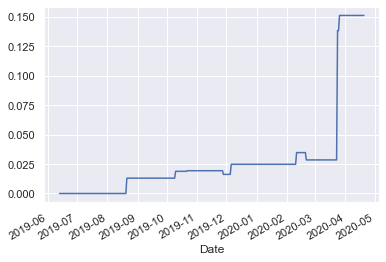

In [387]:
df2 = pd.DataFrame()
df2.index = main.index
df2['VOC'] = indicators['VOC']
df2['PCY'] = indicators['PCY']
df2['Adj Close'] = main['Adj Close']
df2['RETURNS'] = df2['Adj Close'].pct_change().fillna(0)
df2['POS'] = np.where(((df2['VOC'].shift(2) > df2['VOC'].shift(1)) & (df2['VOC'].shift(1) < df2['VOC']) & (df2['PCY'] > df2['PCY'].shift(1))), 1, 0)
df2['STRATEGY'] = df2['POS'].shift(1) * df2['RETURNS']
df2[df2['VOC'] != 0.0]['STRATEGY'].cumsum().plot()
sharpe = df2['STRATEGY'].mean()/df2['STRATEGY'].std() * np.sqrt(252)
print(sharpe)

$BuySignal_i = (VOC_{i-2} > VOC_{i-1}) \wedge (VOC_{i-1} < VOC_{i}) \wedge (PCY_{i} > PCY_{i-1}) \wedge (PCY < \epsilon)$

1.3944699311091797


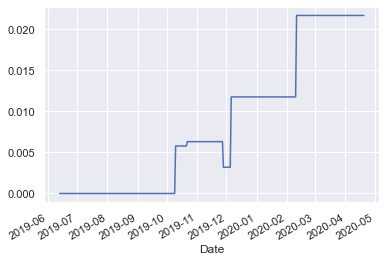

In [425]:
epsilon = 70

f2 = pd.DataFrame()
df2.index = main.index
df2['VOC'] = indicators['VOC']
df2['PCY'] = indicators['PCY']
df2['Adj Close'] = main['Adj Close']
df2['RETURNS'] = df2['Adj Close'].pct_change().fillna(0)
df2['POS'] = np.where(((df2['VOC'].shift(2) > df2['VOC'].shift(1)) & (df2['VOC'].shift(1) < df2['VOC']) & (df2['PCY'] > df2['PCY'].shift(1)) & (df2['PCY'] < epsilon)), 1, 0)
df2['STRATEGY'] = df2['POS'].shift(1) * df2['RETURNS']
df2[df2['VOC'] != 0.0]['STRATEGY'].cumsum().plot()
sharpe = (df2['STRATEGY'].mean()/df2['STRATEGY'].std()) * np.sqrt(252)
print(sharpe)


### High Frequency Trading - VOC and PCY with tuned hyperparameters

In [798]:
btc = pd.read_csv(r'C:\Users\shermanding\Documents\MQF\DRW\Gemini_BTCUSD_1.csv',skiprows=1)[::-1].reset_index(drop=True).drop(['open','high','low','symbol','Volume BTC'],axis=1).rename(columns={'close':'BTC','Volume USD':'Volume'})
btc['date'] = pd.to_datetime(btc['date'], format='%d/%m/%Y %H:%M')

In [797]:
indicators_btc = pd.DataFrame(index=btc.index)
indicators_btc['PCY'] = price_cyclicality_function(btc.reset_index()[['BTC']])['pcy'].values
indicators_btc['VOC'] = price_cyclicality_function(btc.reset_index()[['Volume']])['pcy'].values

### Optimised parameters using grid search

$BuySignal_i = (VOC_{i-1} < VOC_{i}) \wedge (PCY_{i} > PCY_{i-1}) \wedge (PCY < \epsilon) \wedge (VOC < \lambda)$

In [463]:
epsilon = 10
lamb = 90

df_btc = pd.DataFrame()
df_btc.index = btc.index
df_btc['VOC'] = indicators_btc['VOC']
df_btc['PCY'] = indicators_btc['PCY']
df_btc['BTC'] = btc['BTC']
df_btc['RETURNS'] = df_btc['BTC'].pct_change().fillna(0)
df_btc['POS'] = np.where(((df_btc['VOC'].shift(1) < df_btc['VOC']) & (df_btc['PCY'] > df_btc['PCY'].shift(1)) & (df_btc['PCY'] < epsilon) & (df_btc['VOC'] < lamb)), 1, 0)
df_btc['STRATEGY'] = (df_btc['POS'].shift(1) * df_btc['RETURNS']).fillna(0)
df_btc.index = btc['date']

In [777]:
def pnlPerformance(pnl, portfolio, frequency, label):
    import matplotlib.pyplot as plt
    import numpy as np
    if frequency == 'D':
        scale = 252
    elif frequency == 'H':
        scale = 365 * 24

    if portfolio == 'constant':
        cumpnl = pnl.cumsum(skipna = True)
        sharpe = pnl.mean()/np.std(pnl)
        sharpe = sharpe*np.sqrt(scale)
        highwatermark_df = cumpnl.cummax()
        drawdown_df = cumpnl - highwatermark_df
        maxdrawdown = drawdown_df.min()
        print("")
        print('Performance Statistics for '+label)
        print("Daily annualized sharpe: "+str(sharpe))
        print ("Average annual returns: "+str(pnl.mean()*scale*100)+"%")
        print ("Total returns: "+str(pnl.sum()*100)+"%")
        print ("Max drawdown: "+str(maxdrawdown*100)+"%")
        print("")

        bt_dates = pd.to_datetime(cumpnl.index,format='%Y%m%d')
        plt.title("Cumulative PNL chart")
        plt.plot(bt_dates, cumpnl.values + 1, label = label)
        plt.legend()
        plt.show(block=False)
        stressedmarkets = dict()
        stressedmarkets["Covid19"] = (dt.datetime(2020, 3, 1), dt.datetime(2020, 3, 17));          #Market crash 1H March 2020
        print('Stress Tests')
        print('===================================')

        for tkey in stressedmarkets.keys():
            mask = pnl.index.to_series().between(stressedmarkets[tkey][0], stressedmarkets[tkey][1])
            print("Stressed period return during "+tkey+":  "+str(pnl[mask].sum()*100)+"%")
        print("===========================")
        print("")

    elif portfolio == 'reinvest':
        cumpnl = (1 + pnl).cumprod() - 1 
        sharpe = pnl.mean()/np.std(pnl) * np.sqrt(scale)
        highwatermark_df = cumpnl.cummax() + 1
        drawdown_df = ((1+cumpnl) - highwatermark_df) / highwatermark_df
        maxdrawdown = drawdown_df.min()
        print("")
        print('Performance Statistics for '+label)
        print('Daily annualized sharpe: '+str(sharpe))
        print('Average annual returns: '+str(pnl.mean()*scale*100)+'%')
        print('Total returns: '+str(cumpnl.iloc[-1]*100)+'%')
        print('Max drawdown: '+str(maxdrawdown*100)+'%')
        print("")

        bt_dates = pd.to_datetime(cumpnl.index,format='%Y%m%d')
        plt.title("Cumulative PNL chart")
        plt.plot(bt_dates, cumpnl.values + 1, label = label)
        plt.legend()
        plt.show(block=False)

        stressedmarkets = dict()
        stressedmarkets["Covid19"] = (dt.datetime(2020, 3, 1), dt.datetime(2020, 3, 17));          #Market crash 1H March 2020

            # stressedmarkets['Aug2013'] = (20130820, 20130825);          #Flash freeze on 22 Aug 2013
        print('Stress Tests')
        print('===================================')

        for tkey in stressedmarkets.keys():
            mask = pnl.index.to_series().between(stressedmarkets[tkey][0], stressedmarkets[tkey][1])
            stressreturn = ((1+pnl[mask]).cumprod() - 1)
            print('Stressed period return during '+tkey+': '+str(stressreturn.min()*100)+'%')
        print('===================================')
        print('')


### In-sample Performance: Tuned Hyperparameters


Performance Statistics for Capital Evolution
Daily annualized sharpe: 1.4573675812978237
Average annual returns: 19.33533201574147%
Total returns: 22.0833329700335%
Max drawdown: -11.168768693365628%



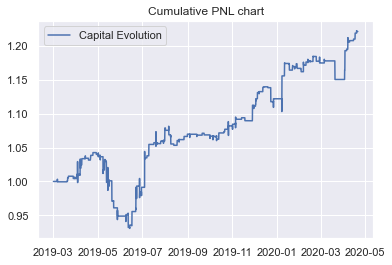

Stress Tests
Stressed period return during Covid19:  0.304356047251475%



In [779]:
pnlPerformance(df_btc['STRATEGY'],'constant', 'H','Capital Evolution')


Performance Statistics for Capital Evolution: Market
Daily annualized sharpe: 1.0368795251950789
Average annual returns: 86.04228750509223%
Total returns: 80.23779546639771%
Max drawdown: -69.93511477414489%



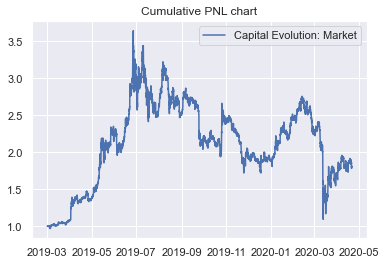

Stress Tests
Stressed period return during Covid19: -51.203090158155916%



In [790]:
pnlPerformance(df_btc['RETURNS'],'reinvest', 'H','Capital Evolution: Market')

### Out-sample Performance: Tuned Parameters

In [799]:
btc2 = pd.read_csv(r'C:\Users\shermanding\Documents\MQF\DRW\Gemini_BTCUSD_3.csv',skiprows=1)[::-1].reset_index(drop=True).drop(['open','high','low','symbol','Volume BTC'],axis=1).rename(columns={'close':'BTC','Volume USD':'Volume'})
btc2['date'] = pd.to_datetime(btc2['date'], format='%d/%m/%Y %H:%M')

In [800]:
indicators_btc2 = pd.DataFrame(index=btc2.index)
indicators_btc2['PCY'] = price_cyclicality_function(btc2.reset_index()[['BTC']])['pcy'].values
indicators_btc2['VOC'] = price_cyclicality_function(btc2.reset_index()[['Volume']])['pcy'].values

In [468]:
epsilon = 10
lamb = 90

df_btc2 = pd.DataFrame()
df_btc2.index = btc2.index
df_btc2['VOC'] = indicators_btc2['VOC']
df_btc2['PCY'] = indicators_btc2['PCY']
df_btc2['BTC'] = btc2['BTC']
df_btc2['RETURNS'] = df_btc2['BTC'].pct_change().fillna(0)
df_btc2['POS'] = np.where(((df_btc2['VOC'].shift(1) < df_btc2['VOC']) & (df_btc2['PCY'] > df_btc2['PCY'].shift(1)) & (df_btc2['PCY'] < epsilon) & (df_btc2['VOC'] < lamb)), 1, 0)
df_btc2['STRATEGY'] = (df_btc2['POS'].shift(1) * df_btc2['RETURNS']).fillna(0)
df_btc2.index = btc2['date']


Performance Statistics for Capital Evolution
Daily annualized sharpe: 0.8173888810933247
Average annual returns: 10.836285639459508%
Total returns: 40.67194469632296%
Max drawdown: -23.143097793436883%


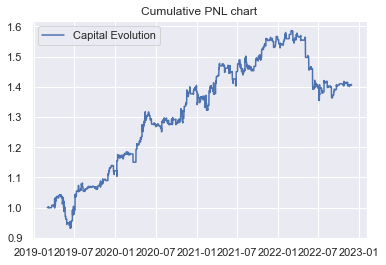

Stress Tests
Stressed period return during Covid19:  0.304356047251475%



In [469]:
pnlPerformance(df_btc2['STRATEGY'],'constant','Capital Evolution')


Performance Statistics for Capital Evolution: Market
Daily annualized sharpe: 0.9030471933063482
Average annual returns: 68.6716188333637%
Total returns: 344.32720319026873%
Max drawdown: -77.19077301791935%



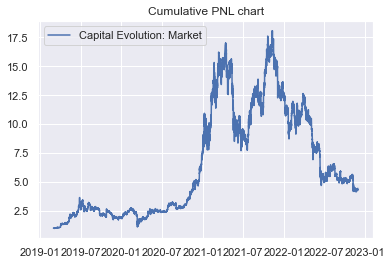

Stress Tests
Stressed period return during Covid19: -51.203090158155916%



In [789]:
pnlPerformance(df_btc2['RETURNS'],'reinvest','H','Capital Evolution: Market')

### Machine learning with Volume and Price cyclicality: BITCOIN

In [ ]:
import pandas as pd
import numpy as np
from pandas_datareader import data as pdr
import datetime as dt
import matplotlib.pyplot as plt
import seaborn as sns

import warnings
warnings.filterwarnings("ignore")

In [717]:
btc_d = pd.read_csv(r'C:\Users\shermanding\Documents\MQF\DRW\Gemini_BTCUSD_d.csv',skiprows=1)[::-1].reset_index(drop=True).drop(['unix','open','symbol','Volume BTC'],axis=1).rename(columns={'low':'Low','high':'High','close':'BTC','Volume USD':'Volume'})
btc_d['date'] = btc_d['date'].str.replace(' 4:00','')
btc_d['date'] = pd.to_datetime(btc_d['date'], format='%d/%m/%Y')
btc_d = btc_d.rename(columns={'date':'Date'})
btc_d

,Date,High,Low,BTC,Volume
0,2016-01-01,437.80,430.51,432.70,5.472379e+04
1,2016-01-02,439.53,427.33,427.33,1.163655e+05
2,2016-01-03,430.18,409.11,426.00,1.510312e+05
3,2016-01-04,436.49,426.00,432.57,1.956430e+05
4,2016-01-05,435.07,427.88,427.88,1.149892e+05
...,...,...,...,...,...
1567,2020-04-16,7219.34,6633.72,7095.71,3.326922e+07
1568,2020-04-17,7159.64,7000.67,7104.85,1.000629e+07
1569,2020-04-18,7303.13,7071.77,7247.14,8.710994e+06
1570,2020-04-19,7256.62,7069.00,7180.39,5.639225e+06


In [718]:
start = dt.datetime(2016, 1, 1)
end = dt.datetime(2020, 4, 20)

currency_tickers = ['DEXJPUS','DEXUSUK','DEXUSEU','DEXCHUS']
index_tickers = ['SP500','DJIA','NASDAQCOM','VIXCLS']

currency_data = pdr.DataReader(currency_tickers,'fred',start=start, end=end)
index_data = pdr.DataReader(index_tickers,'fred',start=start, end=end)

currency_data.index.names = ['Date']
index_data.index.names = ['Date']

# import rest of features
currency2_data = pd.read_csv('currency.csv')
index2_data = pd.read_csv('index.csv')
interest_rate_data = pd.read_csv('interest_rate.csv')
commodity_data = pd.read_csv('commodity.csv')

# formatting
currency2_data['Date'] = pd.to_datetime(currency2_data['Date'], format='%d/%m/%Y')
index2_data['Date'] = pd.to_datetime(index2_data['Date'], format='%d/%m/%Y')
interest_rate_data['Date'] = pd.to_datetime(interest_rate_data['Date'], format='%d/%m/%Y')
commodity_data['Date'] = pd.to_datetime(commodity_data['Date'], format='%d/%m/%Y')
currency2_data = currency2_data.set_index('Date')
index2_data = index2_data.set_index('Date')
commodity_data = commodity_data.set_index('Date')
interest_rate_data  = interest_rate_data.set_index('Date')

# merge data
currency_data = pd.merge(currency_data,currency2_data,how='left',on='Date')
index_data = pd.merge(index_data,index2_data,how='left',on='Date')

# main data
main = pd.merge(btc_d,currency_data,how='left',on='Date')
main = pd.merge(main,index_data,how='left',on='Date')
main = pd.merge(main,commodity_data,how='left',on='Date')
main = pd.merge(main,interest_rate_data,how='left',on='Date')
main = main.fillna(method='ffill')

In [719]:
# shift signal positions as we want to predict positions
main['signal'] = np.where(main['BTC'] > main['BTC'].shift(1), 1.0, 0.0)
main['signal'] = main['signal'].shift(-1).fillna(0)
main['VOC'] = price_cyclicality_function(main[['Volume']])['pcy'].values
main['PCY'] = price_cyclicality_function(main[['BTC']])['pcy'].values
main = main.drop(['High','Low'],axis=1)
main = main.set_index('Date')
main

,BTC,Volume,DEXJPUS,DEXUSUK,DEXUSEU,DEXCHUS,DXY,SP500,DJIA,NASDAQCOM,...,CAC 40,DAX,GC1,SI1,CL1,NG1,FF1,signal,VOC,PCY
Date,,,,,,,,,,,,,,,,,,,,,
2016-01-01,432.70,5.472379e+04,NaN,NaN,NaN,NaN,98.683,NaN,NaN,NaN,...,4637.06,10743.01,1060.2,13.803,37.04,2.337,99.7600,0.0,0.000000,0.000000
2016-01-02,427.33,1.163655e+05,NaN,NaN,NaN,NaN,98.683,NaN,NaN,NaN,...,4637.06,10743.01,1060.2,13.803,37.04,2.337,99.7600,0.0,0.000000,0.000000
2016-01-03,426.00,1.510312e+05,NaN,NaN,NaN,NaN,98.683,NaN,NaN,NaN,...,4637.06,10743.01,1060.2,13.803,37.04,2.337,99.7600,1.0,0.000000,0.000000
2016-01-04,432.57,1.956430e+05,119.30,1.4686,1.0803,6.5338,98.869,2012.66,17148.94,4903.090,...,4522.45,10283.44,1075.2,13.841,36.76,2.334,99.6650,0.0,0.000000,0.000000
2016-01-05,427.88,1.149892e+05,118.95,1.4664,1.0743,6.5219,99.404,2016.71,17158.66,4891.430,...,4537.63,10310.10,1078.4,13.971,35.97,2.325,99.6650,1.0,0.000000,0.000000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2020-04-16,7095.71,3.326922e+07,107.72,1.2433,1.0840,7.0778,100.025,2799.55,23537.68,8532.363,...,4350.16,10301.54,1720.4,15.622,19.87,1.686,99.9450,1.0,99.113681,0.495510
2020-04-17,7104.85,1.000629e+07,107.52,1.2503,1.0883,7.0711,99.782,2874.56,24242.49,8650.141,...,4499.01,10625.78,1689.2,15.295,18.27,1.753,99.9450,1.0,98.352621,0.331992
2020-04-18,7247.14,8.710994e+06,107.52,1.2503,1.0883,7.0711,99.782,2874.56,24242.49,8650.141,...,4499.01,10625.78,1689.2,15.295,18.27,1.753,99.9450,0.0,97.993216,0.222434


In [720]:
# X and Y for Target Outcome
Y = main.dropna(axis=0)['signal']
X = main.dropna(axis=0).loc[:, (main.columns != 'signal')]

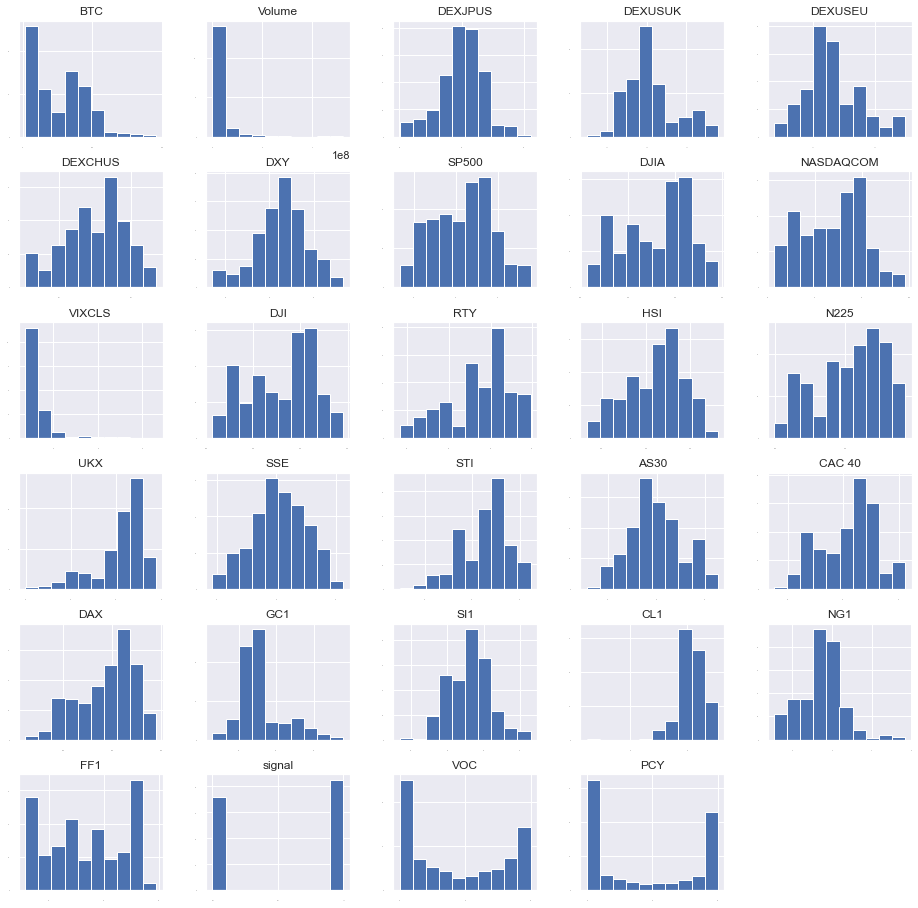

In [721]:
main.hist(sharex = False, sharey = False, xlabelsize = 1, ylabelsize =1, figsize = (16,16))
plt.show()

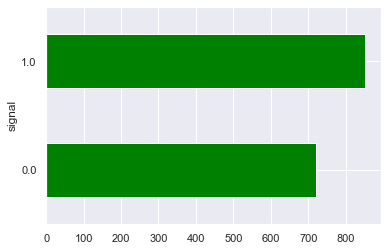

In [788]:
fig = plt.figure()
plot = main.groupby(['signal']).size().plot(kind = "barh", color = "green")
plt.show()

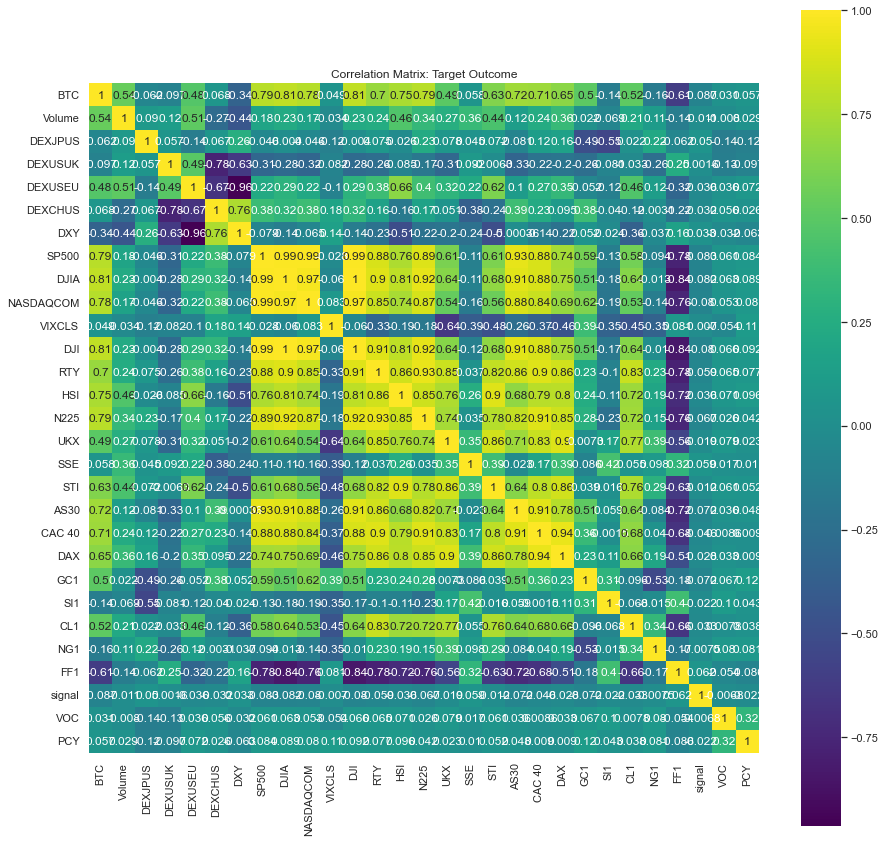

In [722]:
# Correlation matrix for Target Outcome
correlation = main.corr()

plt.figure(figsize=(15,15))
plt.title("Correlation Matrix: Target Outcome")

sns.heatmap(correlation, 
            vmax = 1, 
            square = True,
            annot = True,
            cmap = "viridis")
plt.show()

In [723]:
# train-test split for both outcomes
validation_size = 0.25
train_size = int(len(X) * (1 - validation_size))

X_train, X_test = X[0:train_size], X[train_size:len(X)]
Y_train, Y_test = Y[0:train_size], Y[train_size:len(X)]

### Model Selection 

We test the efficacy of prediction of a target outcome using established supervised learning algorithms.

* Support Vector Classifier
* Logistic Regression
* K Neighbours Classifier
* Decision Tree Classifier
* Gaussian Naive Bayes
* MLP Classifier
* AdaBoost Classifier
* Gradient Boosting Classifier
* Random Forest Classifier

We try to predict the target outcomes below:

> Target Outcome: Predicting next day's BTC price

Variance preserved by first 6 components == 87.74%


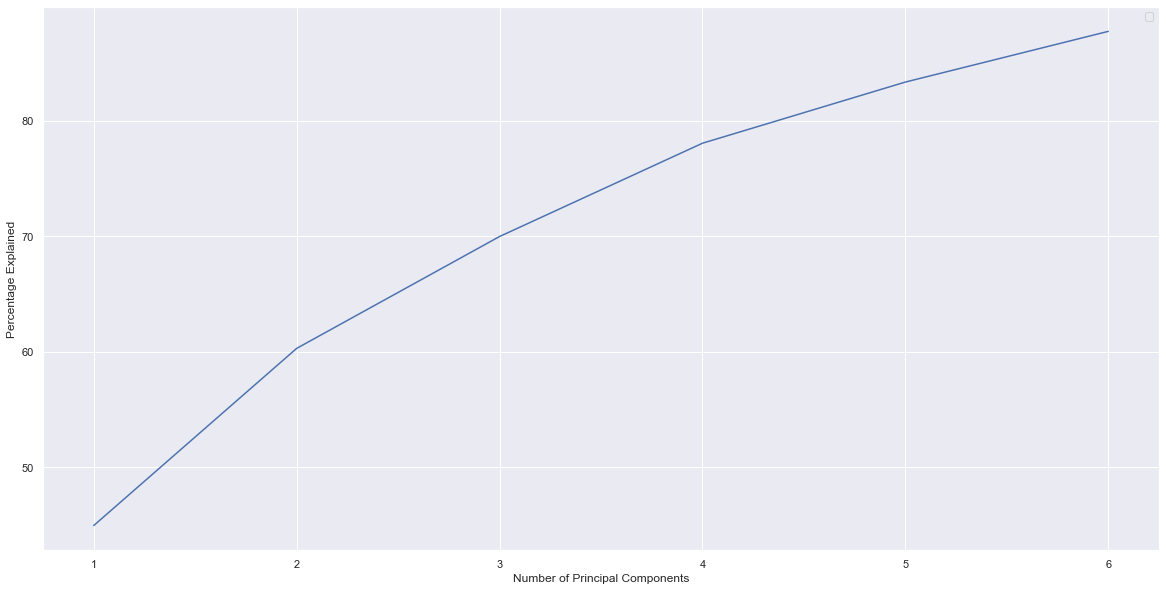

In [753]:
from sklearn.preprocessing import StandardScaler
from scipy.linalg import svd   
from scipy import stats
from sklearn.decomposition import TruncatedSVD
from sklearn.manifold import TSNE
from matplotlib.ticker import MaxNLocator

scaler = StandardScaler().fit(X)
rescaledDataset = pd.DataFrame(scaler.fit_transform(X),columns = X.columns, index = X.index)

# SVD
ncomps = 6
svd = TruncatedSVD(n_components=ncomps)
svd_fit = svd.fit(rescaledDataset)
plt_data = pd.DataFrame(svd_fit.explained_variance_ratio_.cumsum()*100)
plt_data.index = np.arange(1, len(plt_data) + 1)
Y_pred = svd.fit_transform(rescaledDataset)
ax = plt_data.plot(kind="line", figsize=(20, 10))
ax.xaxis.set_major_locator(MaxNLocator(integer = True))

ax.set_xlabel("Number of Principal Components")
ax.set_ylabel("Percentage Explained")
ax.legend("")

print("Variance preserved by first "+str(ncomps) +" components == {:.2%}".format(svd_fit.explained_variance_ratio_.cumsum()[-1]))

In [754]:
# 5 components
dfsvd = pd.DataFrame(Y_pred, columns=["c{}".format(c) for c in range(ncomps)], 
                     index = rescaledDataset.index)
print(dfsvd.shape)
dfsvd.head()

(1569, 6)


,c0,c1,c2,c3,c4,c5
Date,,,,,,
2016-01-04,6.002174,-1.233374,-0.421197,-2.850650,-2.727190,0.962473
2016-01-05,6.062977,-1.160866,-0.552797,-2.707115,-2.749345,0.920287
2016-01-06,6.341640,-1.104446,-0.363028,-2.522343,-2.785970,1.130066
2016-01-07,6.874778,-0.788711,0.180286,-2.784723,-2.306411,0.809808
2016-01-08,7.028211,-0.824021,0.183475,-2.950169,-2.204332,1.034591


In [755]:
# train-test split for both outcomes
validation_size = 0.25
train_size = int(len(dfsvd) * (1 - validation_size))

X_train, X_test = dfsvd[0:train_size], dfsvd[train_size:len(dfsvd)]
Y_train, Y_test = Y[0:train_size], Y[train_size:len(dfsvd)]

In [756]:
# model by accuracy
from sklearn.model_selection import train_test_split
from sklearn.model_selection import KFold
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import GridSearchCV

from sklearn.preprocessing import StandardScaler

from sklearn.metrics import mean_squared_error
from sklearn.feature_selection import chi2, f_regression
from sklearn.feature_selection import SelectKBest

from sklearn.linear_model import LogisticRegression
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis # multi-class

from sklearn.svm import SVC

from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import GradientBoostingClassifier, AdaBoostClassifier, RandomForestClassifier, ExtraTreesClassifier

from sklearn.naive_bayes import GaussianNB

from sklearn.neighbors import KNeighborsClassifier

from sklearn.neural_network import MLPClassifier

from sklearn.pipeline import Pipeline

from sklearn.metrics import classification_report, confusion_matrix, accuracy_score

# 10-fold cross validation
num_folds = 10
seed = 10
scoring = "accuracy"

models = []

models.append(("SVC", SVC()))
models.append(("LR", LogisticRegression(n_jobs = -1)))
models.append(("LDA", LinearDiscriminantAnalysis()))
models.append(("KNN", KNeighborsClassifier()))
models.append(("CART", DecisionTreeClassifier()))
models.append(("NB", GaussianNB()))
models.append(("NN", MLPClassifier()))
models.append(("AB", AdaBoostClassifier()))
models.append(("GBM", GradientBoostingClassifier()))
models.append(("RF", RandomForestClassifier(n_jobs = -1)))

results = []
names = []

print('Target Outcome:')
for name, model in models:
    kfold = KFold(n_splits = num_folds, 
                  random_state = seed, 
                  shuffle = True)
    cv_results = cross_val_score(model, 
                                 X_train, 
                                 Y_train, 
                                 cv = kfold, 
                                 scoring = scoring)
    results.append(cv_results)
    names.append(name)
    msg = "%s: %f (%f)" % (name, cv_results.mean(), cv_results.std())
    print(msg)

Target Outcome:
SVC: 0.563813 (0.045238)
LR: 0.528096 (0.051137)
LDA: 0.528951 (0.051940)
KNN: 0.513617 (0.050546)
CART: 0.496668 (0.033493)
NB: 0.552752 (0.048318)
NN: 0.558685 (0.047138)
AB: 0.531472 (0.044037)
GBM: 0.511053 (0.041389)
RF: 0.483855 (0.037781)


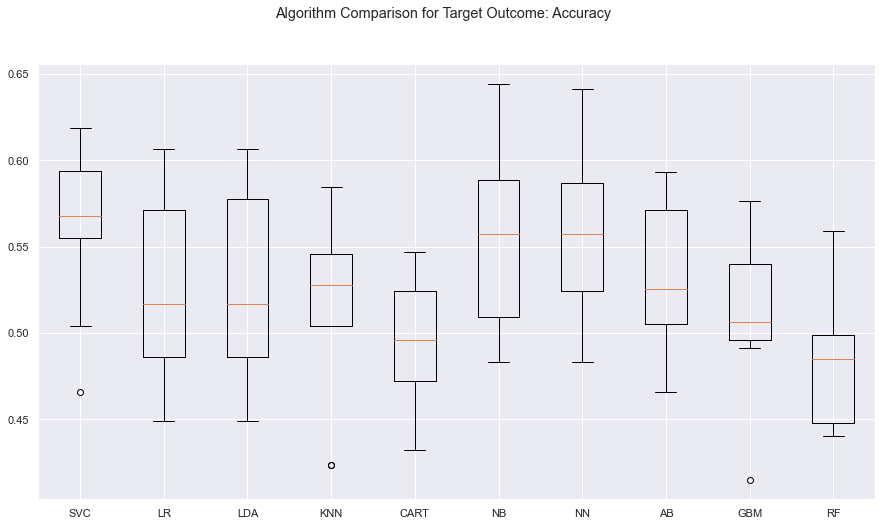

In [757]:
fig = plt.figure()
fig.suptitle("Algorithm Comparison for Target Outcome: Accuracy")
ax = fig.add_subplot(111)
plt.boxplot(results)
ax.set_xticklabels(names)
fig.set_size_inches(15,8)
plt.show()

In [758]:
# Grid Search: SVC
scaler = StandardScaler().fit(X_train)
rescaledX = scaler.transform(X_train)

C = [0.1,1, 10, 100]
gamma = [1,0.1,0.01,0.001]
kernel = ['rbf', 'poly', 'sigmoid']

param_grid = dict(C = C, gamma = gamma, kernel = kernel)

model = SVC()
kfold = KFold(n_splits = num_folds, random_state = seed, shuffle = True)
grid = GridSearchCV(estimator = model, param_grid = param_grid, scoring = scoring, cv = kfold)
grid_result = grid.fit(rescaledX, Y_train)

# Print .
print("Best: %f using %s" % (grid_result.best_score_, grid_result.best_params_))
means = grid_result.cv_results_["mean_test_score"]
stds = grid_result.cv_results_["std_test_score"]
params = grid_result.cv_results_["params"]
ranks = grid_result.cv_results_["rank_test_score"]

for mean, stdev, param, rank in zip(means, stds, params, ranks):
    print("#%d %f (%f) with: %r" % (rank, mean, stdev, param))

Best: 0.562886 using {'C': 1, 'gamma': 0.1, 'kernel': 'poly'}
#21 0.552723 (0.058152) with: {'C': 0.1, 'gamma': 1, 'kernel': 'rbf'}
#25 0.549334 (0.031503) with: {'C': 0.1, 'gamma': 1, 'kernel': 'poly'}
#32 0.541627 (0.039756) with: {'C': 0.1, 'gamma': 1, 'kernel': 'sigmoid'}
#28 0.546798 (0.054221) with: {'C': 0.1, 'gamma': 0.1, 'kernel': 'rbf'}
#3 0.555273 (0.059013) with: {'C': 0.1, 'gamma': 0.1, 'kernel': 'poly'}
#23 0.551036 (0.056889) with: {'C': 0.1, 'gamma': 0.1, 'kernel': 'sigmoid'}
#6 0.553578 (0.059960) with: {'C': 0.1, 'gamma': 0.01, 'kernel': 'rbf'}
#6 0.553578 (0.059960) with: {'C': 0.1, 'gamma': 0.01, 'kernel': 'poly'}
#6 0.553578 (0.059960) with: {'C': 0.1, 'gamma': 0.01, 'kernel': 'sigmoid'}
#6 0.553578 (0.059960) with: {'C': 0.1, 'gamma': 0.001, 'kernel': 'rbf'}
#6 0.553578 (0.059960) with: {'C': 0.1, 'gamma': 0.001, 'kernel': 'poly'}
#6 0.553578 (0.059960) with: {'C': 0.1, 'gamma': 0.001, 'kernel': 'sigmoid'}
#37 0.537440 (0.060301) with: {'C': 1, 'gamma': 1, 'kernel

In [772]:
# prepare model based on tuned hyperparameters
model = SVC(C = 1,
        gamma = 0.1,
        kernel = 'poly',
        random_state = seed)
model.fit(X_train, Y_train)

# estimate accuracy on validation set
predictions = model.predict(X_test)

print(accuracy_score(Y_test, predictions))
print(confusion_matrix(Y_test, predictions))
print(classification_report(Y_test, predictions))

0.549618320610687
[[ 87 107]
 [ 70 129]]
              precision    recall  f1-score   support

         0.0       0.55      0.45      0.50       194
         1.0       0.55      0.65      0.59       199

    accuracy                           0.55       393
   macro avg       0.55      0.55      0.54       393
weighted avg       0.55      0.55      0.55       393



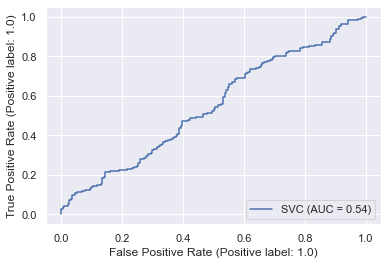

In [773]:
# plot roc ruve
from sklearn import metrics

metrics.plot_roc_curve(model, X_test, Y_test)

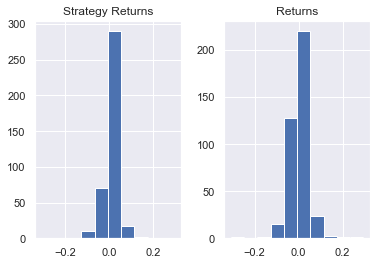

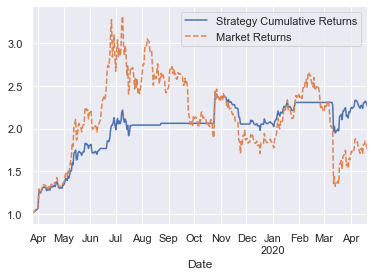

In [774]:
#Create column for Strategy Returns by multiplying the daily returns by the position that was held at close
#of business the previous day
backtest_svc = pd.DataFrame(index=X_test.index)

backtest_svc["signal_pred"] = predictions
backtest_svc["signal_actual"] = Y_test
backtest_svc['Returns'] = main[main.index.isin(Y_test.index)]['BTC'].pct_change().fillna(0)
backtest_svc["Market Returns"] = (1 + backtest_svc["Returns"]).cumprod()
backtest_svc["Strategy Returns"] = backtest_svc["Returns"] * backtest_svc["signal_pred"].shift(1)
backtest_svc["Strategy Cumulative Returns"] = backtest_svc["Strategy Returns"].cumsum() + 1

backtest_svc[["Strategy Returns","Returns"]].hist()
backtest_svc[["Strategy Cumulative Returns","Market Returns"]].plot(style=["-","--"])
plt.show()


In [762]:
# Grid Search: MLP Classifier
scaler = StandardScaler().fit(X_train)
rescaledX = scaler.transform(X_train)

hidden_layer_sizes = [(10,),(20,)]
activation = ['tanh','relu']
solver = ['adam','sgd']
alpha = [0.001, 0.01, 0.1, 1]
learning_rate = ['constant','adaptive']

param_grid = dict(hidden_layer_sizes = hidden_layer_sizes, activation = activation, solver = solver, alpha = alpha, learning_rate = learning_rate)

model = MLPClassifier()
kfold = KFold(n_splits = num_folds, random_state = seed, shuffle = True)
grid = GridSearchCV(estimator = model, param_grid = param_grid, scoring = scoring, cv = kfold)
grid_result = grid.fit(rescaledX, Y_train)

# Print .
print("Best: %f using %s" % (grid_result.best_score_, grid_result.best_params_))
means = grid_result.cv_results_["mean_test_score"]
stds = grid_result.cv_results_["std_test_score"]
params = grid_result.cv_results_["params"]
ranks = grid_result.cv_results_["rank_test_score"]

for mean, stdev, param, rank in zip(means, stds, params, ranks):
    print("#%d %f (%f) with: %r" % (rank, mean, stdev, param))

Best: 0.558750 using {'activation': 'tanh', 'alpha': 1, 'hidden_layer_sizes': (10,), 'learning_rate': 'adaptive', 'solver': 'sgd'}
#59 0.529857 (0.055223) with: {'activation': 'tanh', 'alpha': 0.001, 'hidden_layer_sizes': (10,), 'learning_rate': 'constant', 'solver': 'adam'}
#31 0.543409 (0.056385) with: {'activation': 'tanh', 'alpha': 0.001, 'hidden_layer_sizes': (10,), 'learning_rate': 'constant', 'solver': 'sgd'}
#56 0.533261 (0.038800) with: {'activation': 'tanh', 'alpha': 0.001, 'hidden_layer_sizes': (10,), 'learning_rate': 'adaptive', 'solver': 'adam'}
#39 0.540062 (0.063015) with: {'activation': 'tanh', 'alpha': 0.001, 'hidden_layer_sizes': (10,), 'learning_rate': 'adaptive', 'solver': 'sgd'}
#54 0.534898 (0.050943) with: {'activation': 'tanh', 'alpha': 0.001, 'hidden_layer_sizes': (20,), 'learning_rate': 'constant', 'solver': 'adam'}
#60 0.529031 (0.062962) with: {'activation': 'tanh', 'alpha': 0.001, 'hidden_layer_sizes': (20,), 'learning_rate': 'constant', 'solver': 'sgd'}
#2

In [767]:
# prepare model based on tuned hyperparameters
model = MLPClassifier(activation = 'tanh',
                               alpha = 1,
                               learning_rate = 'adaptive',
                               hidden_layer_sizes = (10,),
                               solver = 'sgd',
                               random_state = seed)
model.fit(X_train, Y_train)

# estimate accuracy on validation set
predictions = model.predict(X_test)

print(accuracy_score(Y_test, predictions))
print(confusion_matrix(Y_test, predictions))
print(classification_report(Y_test, predictions))

0.5343511450381679
[[153  41]
 [142  57]]
              precision    recall  f1-score   support

         0.0       0.52      0.79      0.63       194
         1.0       0.58      0.29      0.38       199

    accuracy                           0.53       393
   macro avg       0.55      0.54      0.50       393
weighted avg       0.55      0.53      0.50       393



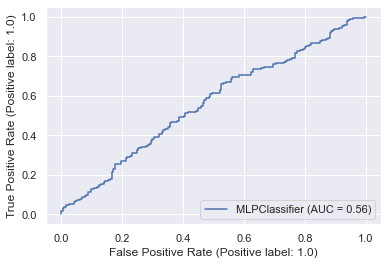

In [768]:
# plot roc ruve
from sklearn import metrics

metrics.plot_roc_curve(model, X_test, Y_test)

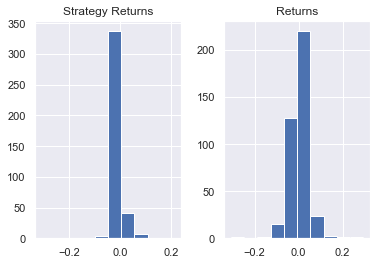

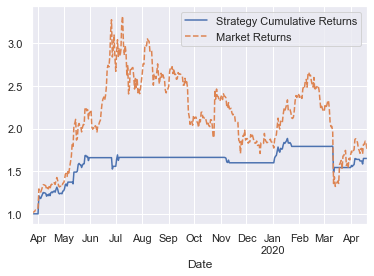

In [764]:
#Create column for Strategy Returns by multiplying the daily returns by the position that was held at close
#of business the previous day
backtest_nn = pd.DataFrame(index=X_test.index)

backtest_nn["signal_pred"] = predictions
backtest_nn["signal_actual"] = Y_test
backtest_nn['Returns'] = main[main.index.isin(Y_test.index)]['BTC'].pct_change().fillna(0)
backtest_nn["Market Returns"] = (1 + backtest_nn["Returns"]).cumprod()
backtest_nn["Strategy Returns"] = backtest_nn["Returns"] * backtest_nn["signal_pred"].shift(1)
backtest_nn["Strategy Cumulative Returns"] = backtest_nn["Strategy Returns"].cumsum() + 1

backtest_nn[["Strategy Returns","Returns"]].hist()
backtest_nn[["Strategy Cumulative Returns","Market Returns"]].plot(style=["-","--"])
plt.show()

In [782]:
# get arithmetic returns
svc_ret = backtest_svc['Strategy Returns']
nn_ret = backtest_nn['Strategy Returns']
market_ret = backtest_svc['Returns']


Performance Statistics for Capital Evolution: SVC
Daily annualized sharpe: 1.3178241038857927
Average annual returns: 81.5641025254228%
Total returns: 126.87749281732437%
Max drawdown: -45.90185045719986%



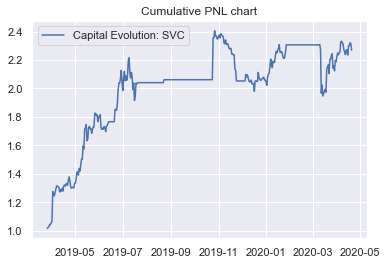

Stress Tests
Stressed period return during Covid19:  -31.296147350980043%



In [784]:
pnlPerformance(svc_ret, 'constant', 'D','Capital Evolution: SVC')


Performance Statistics for Capital Evolution: MLP
Daily annualized sharpe: 1.0013303092878625
Average annual returns: 41.745649289527655%
Total returns: 64.93767667259857%
Max drawdown: -39.86594630190903%



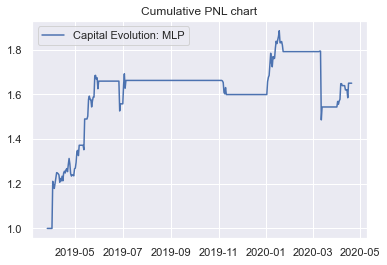

Stress Tests
Stressed period return during Covid19:  -24.767528485755662%



In [786]:
pnlPerformance(nn_ret, 'constant', 'D','Capital Evolution: MLP')


Performance Statistics for Capital Evolution: Market
Daily annualized sharpe: 0.8678443181106777
Average annual returns: 61.294715412383695%
Total returns: 75.56034956508807%
Max drawdown: -60.1902517176573%



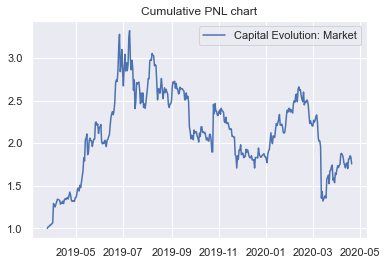

Stress Tests
Stressed period return during Covid19: -40.03944452823184%



In [787]:
pnlPerformance(market_ret, 'reinvest', 'D','Capital Evolution: Market')